In [1]:
!python3 -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 28.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import re
import time
import math
import random
import ast
import numpy as np
import pandas as pd
import spacy
import ru_core_news_sm

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from typing import Tuple
from tqdm import tqdm

import torch.optim as optim
from torch import Tensor
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
import matplotlib.pyplot as plt

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# from seq2seq_attention.visualize_attention import get_attention_frames

from tqdm import notebook
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
from torchtext.vocab import vocab
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [4]:
#df = pd.read_csv("/content/gdrive/MyDrive/rus.txt", sep="\t", names=["English", "Russian", "lic"])
#loading already tokenized data
df = pd.read_csv("/content/gdrive/MyDrive/tokenizer_data.csv")

In [5]:
df.head(50)

,Unnamed: 0,English,Russian
0,0,['go'],['марш']
1,1,['go'],['иди']
2,2,['go'],['идите']
3,3,['hi'],['здравствуйте']
4,4,['hi'],['привет']
5,5,['hi'],['хай']
6,6,['hi'],['здрасте']
7,7,['hi'],"['здоро', 'во']"
8,8,['hi'],['приветик']
9,9,['run'],['беги']


In [ ]:
#df.drop("lic", axis=1, inplace=True)

In [6]:
#CFG
# max_eng_len = 40
# max_rus_len = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#def clean_text(text):
   #text = text.lower()
   #pattern = re.compile('\W')
   #text = re.sub(pattern,' ',text).strip()
#return text

In [ ]:
#df.English = df.English.apply(clean_text)
#df.Russian = df.Russian.apply(clean_text)

In [7]:
# Load the Russian model
rus_tokenizer = spacy.load("ru_core_news_sm")

# Load the English model
eng_tokenizer = spacy.load("en_core_web_sm")

In [8]:
def tokenize_russian(text):
  return [tok.text for tok in rus_tokenizer.tokenizer(text)]

# Tokenizes English text from a string into a list of tokens
def tokenize_en(text):
  return [tok.text for tok in eng_tokenizer.tokenizer(text)]

In [9]:
def build_vocab(series, tokenizer):
    counter = Counter()
    for text in series:
        counter.update(tokenizer(text))
    # Sort tokens by frequency and extract only the tokens, not their frequencies
    sorted_tokens = sorted(counter.keys(), key=lambda token: -counter[token])
    # Create a Vocab object with these sorted tokens, and specify special tokens
    return vocab(OrderedDict((token, 1) for token in sorted_tokens), specials=['<unk>', '<pad>', '<bos>', '<eos>'])

In [10]:
def spacy_tokenizer(text, tokenizer):
 return [tok.text for tok in tokenizer(text)]

In [ ]:
#df.Russian = df.Russian.apply(lambda text: spacy_tokenizer(text, rus_tokenizer))
#df.English = df.English.apply(lambda text: spacy_tokenizer(text, eng_tokenizer))

In [ ]:
#df.to_csv("/content/gdrive/MyDrive/tokenizer_data.csv")

In [11]:
df['English'] = df['English'].apply(ast.literal_eval)
df['Russian'] = df['Russian'].apply(ast.literal_eval)

In [12]:
df.English[0]

['go']

In [13]:
ru_vocab = build_vocab(df.Russian, lambda tokens: tokens) # Since df.Russian is already tokenized
en_vocab = build_vocab(df.English, lambda tokens: tokens) # Since df.English is already tokenized

In [14]:
len(ru_vocab)

60048

In [15]:
len(en_vocab)

17579

In [16]:
def data_process(df, ru_vocab, en_vocab):
    data = []
    for _, row in df.iterrows():
        eng_tokens = row['English']
        rus_tokens = row['Russian']

        # Convert tokens to tensor indices using vocabularies
        ru_tensor_ = torch.tensor([ru_vocab[token] if token in ru_vocab else ru_vocab['<unk>'] for token in rus_tokens], dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] if token in en_vocab else en_vocab['<unk>'] for token in eng_tokens], dtype=torch.long)
        data.append((ru_tensor_, en_tensor_))
    return data

In [17]:
# train_df = df.loc[:int(len(df)*0.9)]
# val_df = df.loc[int(len(df)*0.9):]
train_df, val_df = train_test_split(df, test_size = 0.2, shuffle = True)
train_data = data_process(train_df, ru_vocab, en_vocab)
val_data = data_process(val_df, ru_vocab, en_vocab)

In [18]:
train_df.head()

,Unnamed: 0,English,Russian
237071,237071,"[she, decided, to, quit, her, job]","[она, решила, уйти, с, работы]"
116059,116059,"[put, on, something, else]","[надень, что, нибудь, другое]"
245259,245259,"[why, are, you, siding, with, tom]","[почему, ты, встаёшь, на, сторону, тома]"
337354,337354,"[tom, looks, about, thirty, years, old]","[том, выглядит, лет, на, тридцать]"
447310,447310,"[did, you, know, tom, had, a, house, on, park, street]","[вы, знали, , что, у, тома, есть, дом, на, парк, стрит]"


In [19]:
train_data[:5]

[(tensor([  49, 1828,  344,   16,  426]),
  tensor([ 67, 317,   7, 664, 103, 220])),
 (tensor([2606,    8,   69, 1319]), tensor([167,  45, 113, 221])),
 (tensor([  42,   11, 6554,   14, 1957,   18]),
  tensor([   55,    33,     5, 10953,    40,     6])),
 (tensor([  7, 438, 179,  14, 384]), tensor([  6, 319,  54, 406, 215, 186])),
 (tensor([  12,  242,    4,    8,   15,   18,   43,  182,   14,  946, 1822]),
  tensor([ 37,   5,  27,   6,  76,  11, 162,  45, 391, 516]))]

In [20]:
BATCH_SIZE = 128
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

In [21]:
def generate_batch(data_batch):
  ru_batch, en_batch = [], []
  for (ru_item, en_item) in data_batch:
    ru_batch.append(torch.cat([torch.tensor([BOS_IDX]), ru_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
  ru_batch = pad_sequence(ru_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return ru_batch, en_batch # (T, batch_size) output

In [22]:
train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)

In [23]:
class Encoder(nn.Module):

  def __init__(self, input_dim, hidden_size, embedding_size, num_layers=2, dropout=0.3):

    super(Encoder, self).__init__()

    # Basic network params
    self.hidden_size = hidden_size
    self.embedding_size = embedding_size
    self.num_layers = num_layers
    self.dropout = dropout

    # Embedding layer that will be shared with Decoder
    self.embedding = nn.Embedding(input_dim, embedding_size)
    # GRU layer
    self.gru = nn.GRU(embedding_size, hidden_size,
                      num_layers=num_layers,
                      dropout=dropout)

  def forward(self, input_sequence):

    # Convert input_sequence to word embeddings
    embedded = self.embedding(input_sequence)

    outputs, hidden = self.gru(embedded)

    # The ouput of a GRU has shape -> (seq_len, batch, hidden_size)
    return outputs, hidden

In [24]:
class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()
    self.hidden_size = hidden_size


  def dot_score(self, hidden_state, encoder_states):
    return torch.sum(hidden_state * encoder_states, dim=2)


  def forward(self, hidden, encoder_outputs, mask):
    # print(f"mask shape = {mask.shape}")
    attn_scores = self.dot_score(hidden, encoder_outputs)

    # Transpose max_length and batch_size dimensions
    attn_scores = attn_scores.t()

    # Apply mask so network does not attend <pad> tokens
    attn_scores = attn_scores.masked_fill(mask == 0, -1e5)

    # Return softmax over attention scores
    return F.softmax(attn_scores, dim=1).unsqueeze(1)

In [25]:
class Decoder(nn.Module):
  def __init__(self, embedding_size, hidden_size, output_size, n_layers=2, dropout=0.3):

    super(Decoder, self).__init__()

    # Basic network params
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    self.dropout = dropout
    self.embedding = nn.Embedding(output_size, embedding_size)

    self.gru = nn.GRU(embedding_size, hidden_size, n_layers,
                      dropout=dropout)

    self.concat = nn.Linear(hidden_size * 2, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.attn = Attention(hidden_size)

  def forward(self, current_token, hidden_state, encoder_outputs, mask):

    # convert current_token to word_embedding
    embedded = self.embedding(current_token)

    # Pass through GRU
    gru_output, hidden_state = self.gru(embedded, hidden_state)
    # print(f"decoder gru output shape = {gru_output.shape}")
    # print(f"encoder output shape for attention = {encoder_outputs.shape}")

    # Calculate attention weights
    attention_weights = self.attn(gru_output, encoder_outputs, mask)

    # Calculate context vector (weigthed average)
    context = attention_weights.bmm(encoder_outputs.transpose(0, 1))

    # Concatenate  context vector and GRU output
    gru_output = gru_output.squeeze(0)
    context = context.squeeze(1)
    concat_input = torch.cat((gru_output, context), 1)
    concat_output = torch.tanh(self.concat(concat_input))

    # Pass concat_output to final output layer
    output = self.out(concat_output)

    # Return output and final hidden state
    return output, hidden_state, attention_weights

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module, device: torch.device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def create_mask(self, input_sequence):
      return (input_sequence != PAD_IDX).permute(1, 0)

    def forward(self, src, trg=None, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        encoder_outputs, hidden = self.encoder(src)

        if trg is None:
            max_len = 50  # Define max_len for inference if trg is not provided
            sos_token_index = BOS_IDX
            trg = torch.full((max_len, batch_size), sos_token_index, dtype=torch.long, device=self.device)
        else:
            max_len = trg.shape[0]  # Use provided trg to determine sequence length

        trg_vocab_size = self.decoder.output_size
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size, device=self.device)
        attentions = torch.zeros(max_len, batch_size, src.shape[0], device=self.device)

        # First input to the decoder is the <sos> token
        input = trg[0, :]
        mask = self.create_mask(src)

        for t in range(1, max_len):
            input = input.unsqueeze(0)
            output, hidden, attn = self.decoder(input, hidden, encoder_outputs, mask)
            # print(output.shape)
            # print(hidden.shape)
            # print(attn.shape)
            outputs[t] = output
            attentions[t] = attn.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if (teacher_force and t < trg.shape[0]) else top1

        return outputs, attentions

In [27]:
INPUT_DIM = len(ru_vocab)
OUTPUT_DIM = len(en_vocab)

ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
ENC_HID_DIM = 128
DEC_HID_DIM = 128
ATTN_DIM = 64
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3
NUM_LAYERS = 1

enc = Encoder(INPUT_DIM, ENC_HID_DIM, ENC_EMB_DIM, NUM_LAYERS, ENC_DROPOUT)

# attn = Attention(ENC_HID_DIM)

dec = Decoder(DEC_EMB_DIM, DEC_HID_DIM, OUTPUT_DIM, NUM_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)


def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

optimizer = optim.Adam(model.parameters())


def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,417,707 trainable parameters


In [28]:
PAD_IDX = en_vocab.get_stoi()['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [29]:
def indices_to_words(indices, vocab):
    # Convert indices to words using TorchText vocab
    words = []
    for idx in indices:
        if(idx != PAD_IDX and idx != BOS_IDX and idx != EOS_IDX):
          word = vocab.get_itos()[idx]
          words.append(word)
    return words

def calculate_bleu(data_loader, model, device, vocab):
    model.eval()
    targets = []
    predictions = []

    with torch.no_grad():
        for src, trg in tqdm(data_loader):
            src, trg = src.to(device), trg.to(device)
            output, attn = model(src, trg, 0)  # Assume model returns logits
            output = output.argmax(-1)
            # Transpose output to match (batch_size, T) format
            output = output.transpose(0, 1)
            trg = trg.transpose(0, 1)
            predictions.extend(output.cpu().numpy().tolist())
            targets.extend(trg.cpu().numpy().tolist())

    # Convert indices to words
    targets = [indices_to_words(t, vocab) for t in targets]
    predictions = [indices_to_words(p, vocab) for p in predictions]

    # Calculate BLEU score
    bleu_score = corpus_bleu([[t] for t in targets], predictions)
    return bleu_score

In [ ]:
# del model
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
def train(model: nn.Module,
          iterator: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0
    for _, (src, trg) in tqdm(enumerate(iterator)):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        output, attn = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def evaluate(model: nn.Module,
             iterator: torch.utils.data.DataLoader,
             criterion: nn.Module):

    model.eval()

    epoch_loss = 0
    example_outputs = []

    with torch.no_grad():

        for _, (src, trg) in tqdm(enumerate(iterator)):
            src, trg = src.to(device), trg.to(device)

            output, attn = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

            # Print example outputs and their corresponding targets
    for pred, target in example_outputs:
        print("Predicted:", pred)
        print("Target:", target)

    return epoch_loss / len(iterator)


def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

train_losses = []
val_losses = []
best_loss = 100000

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)
    # valid_bleu = calculate_bleu(valid_iter, model, device, ru_vocab)  # Make sure device is defined

    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model, "/content/gdrive/MyDrive/Russian_English_model_1layer_GRU.pt")

    train_losses.append(train_loss)
    val_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    # print(f'\t Val. BLEU: {valid_bleu:.2f}')

3101it [03:37, 14.27it/s]
776it [00:15, 50.42it/s]


Epoch: 01 | Time: 3m 52s
	Train Loss: 5.562 | Train PPL: 260.269
	 Val. Loss: 5.528 |  Val. PPL: 251.735


3101it [03:37, 14.28it/s]
776it [00:15, 50.46it/s]


Epoch: 02 | Time: 3m 52s
	Train Loss: 4.056 | Train PPL:  57.753
	 Val. Loss: 3.640 |  Val. PPL:  38.104


3101it [03:38, 14.20it/s]
776it [00:15, 50.45it/s]


Epoch: 03 | Time: 3m 53s
	Train Loss: 2.534 | Train PPL:  12.605
	 Val. Loss: 2.757 |  Val. PPL:  15.759


3101it [03:37, 14.26it/s]
776it [00:15, 50.41it/s]


Epoch: 04 | Time: 3m 52s
	Train Loss: 1.860 | Train PPL:   6.421
	 Val. Loss: 2.453 |  Val. PPL:  11.626


3101it [03:36, 14.30it/s]
776it [00:15, 50.65it/s]


Epoch: 05 | Time: 3m 52s
	Train Loss: 1.547 | Train PPL:   4.696
	 Val. Loss: 2.270 |  Val. PPL:   9.675


3101it [03:36, 14.33it/s]
776it [00:15, 50.63it/s]


Epoch: 06 | Time: 3m 51s
	Train Loss: 1.350 | Train PPL:   3.858
	 Val. Loss: 2.146 |  Val. PPL:   8.551


3101it [03:36, 14.35it/s]
776it [00:15, 51.05it/s]


Epoch: 07 | Time: 3m 51s
	Train Loss: 1.216 | Train PPL:   3.372
	 Val. Loss: 2.095 |  Val. PPL:   8.126


3101it [03:36, 14.32it/s]
776it [00:15, 50.66it/s]


Epoch: 08 | Time: 3m 52s
	Train Loss: 1.107 | Train PPL:   3.026
	 Val. Loss: 2.078 |  Val. PPL:   7.989


3101it [03:36, 14.33it/s]
776it [00:15, 50.63it/s]


Epoch: 09 | Time: 3m 51s
	Train Loss: 1.030 | Train PPL:   2.801
	 Val. Loss: 2.012 |  Val. PPL:   7.479


3101it [03:36, 14.32it/s]
776it [00:15, 50.73it/s]


Epoch: 10 | Time: 3m 51s
	Train Loss: 0.962 | Train PPL:   2.617
	 Val. Loss: 1.994 |  Val. PPL:   7.348


3101it [03:36, 14.31it/s]
776it [00:15, 50.15it/s]


Epoch: 11 | Time: 3m 52s
	Train Loss: 0.905 | Train PPL:   2.471
	 Val. Loss: 2.014 |  Val. PPL:   7.497


3101it [03:37, 14.25it/s]
776it [00:15, 50.49it/s]


Epoch: 12 | Time: 3m 52s
	Train Loss: 0.860 | Train PPL:   2.363
	 Val. Loss: 1.997 |  Val. PPL:   7.364


3101it [03:37, 14.25it/s]
776it [00:15, 50.21it/s]


Epoch: 13 | Time: 3m 53s
	Train Loss: 0.820 | Train PPL:   2.271
	 Val. Loss: 2.004 |  Val. PPL:   7.419


3101it [03:42, 13.93it/s]
776it [00:15, 50.51it/s]


Epoch: 14 | Time: 3m 57s
	Train Loss: 0.783 | Train PPL:   2.188
	 Val. Loss: 2.037 |  Val. PPL:   7.670


3101it [03:38, 14.21it/s]
776it [00:15, 50.69it/s]


Epoch: 15 | Time: 3m 53s
	Train Loss: 0.756 | Train PPL:   2.130
	 Val. Loss: 2.019 |  Val. PPL:   7.529


3101it [03:37, 14.26it/s]
776it [00:15, 50.71it/s]


Epoch: 16 | Time: 3m 52s
	Train Loss: 0.728 | Train PPL:   2.072
	 Val. Loss: 2.010 |  Val. PPL:   7.462


3101it [03:38, 14.22it/s]
776it [00:15, 50.10it/s]


Epoch: 17 | Time: 3m 53s
	Train Loss: 0.708 | Train PPL:   2.029
	 Val. Loss: 2.017 |  Val. PPL:   7.516


3101it [03:35, 14.36it/s]
776it [00:15, 50.80it/s]


Epoch: 18 | Time: 3m 51s
	Train Loss: 0.684 | Train PPL:   1.981
	 Val. Loss: 2.039 |  Val. PPL:   7.684


3101it [03:37, 14.27it/s]
776it [00:15, 50.59it/s]


Epoch: 19 | Time: 3m 52s
	Train Loss: 0.664 | Train PPL:   1.943
	 Val. Loss: 2.035 |  Val. PPL:   7.652


3101it [03:37, 14.26it/s]
776it [00:15, 50.41it/s]

Epoch: 20 | Time: 3m 52s
	Train Loss: 0.653 | Train PPL:   1.921
	 Val. Loss: 2.064 |  Val. PPL:   7.878


Text(0, 0.5, 'loss')

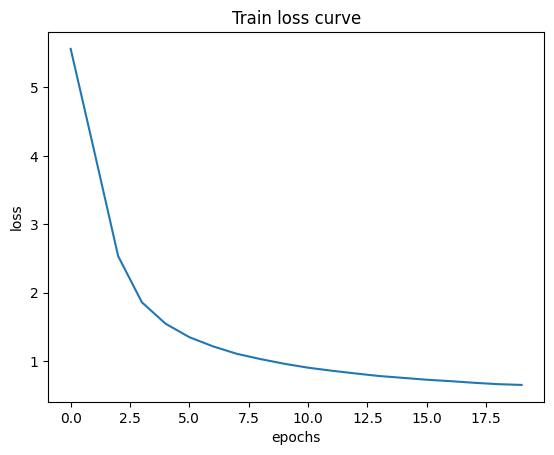

In [ ]:
eps = [i for i in range(N_EPOCHS)]
plt.plot(eps, train_losses)
plt.title(f"Train loss curve")
plt.xlabel("epochs")
plt.ylabel("loss")

In [30]:
#russian to english translation and attention map
def get_translation_and_attention_frame(sentence, model, rus_tokenizer, eng_vocab, russian_vocab):
  model.eval()
  tokenized_sen = [tok.text for tok in rus_tokenizer.tokenizer(sentence)]
  ru_tensor_ = torch.tensor([russian_vocab[token] if token in russian_vocab else russian_vocab['<unk>'] for token in tokenized_sen], dtype=torch.long)
  input = torch.cat([torch.tensor([BOS_IDX]), ru_tensor_, torch.tensor([EOS_IDX])], dim=0).to(device)

  input = input.unsqueeze(-1)
  output, attn = model(input)
  translation_tensor = torch.argmax(output.squeeze(1), -1)
  translation = [eng_vocab.get_itos()[t] for t in translation_tensor]

  translation = translation[1:]
  attn = attn.squeeze(1)[1:, :]
  first_eos_token = 0
  for c, i in enumerate(translation):
    if(i == "<eos>"):
      first_eos_token = c
      break
  translation = translation[:first_eos_token+1]
  attn_frames = attn[:first_eos_token+1, 1:]
  frame = pd.DataFrame(attn_frames.detach().cpu().numpy())
  frame.columns = tokenized_sen + ["<eos>"]
  frame.index = translation

  return translation, frame

In [31]:
def plot_attention(attention_frame):
  sns.heatmap(attention_frame, cmap="bone", vmin=0, vmax=1)
  plt.yticks(rotation=0)
  plt.gca().xaxis.tick_top()
  plt.gca().xaxis.set_label_position("top")
  plt.xticks(rotation=45)

  return plt.gcf()

In [ ]:
model = torch.load("/content/gdrive/MyDrive/Russian_English_model_2layer_GRU.pt")

In [ ]:
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(60048, 64)
    (gru): GRU(64, 128, num_layers=2, dropout=0.3)
  )
  (decoder): Decoder(
    (embedding): Embedding(17579, 64)
    (gru): GRU(64, 128, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=256, out_features=128, bias=True)
    (out): Linear(in_features=128, out_features=17579, bias=True)
    (attn): Attention()
  )
)

In [ ]:
calculate_bleu(valid_iter, model, device, en_vocab)

100%|██████████| 776/776 [00:17<00:00, 44.08it/s]


0.5073643523217178

In [44]:
model = torch.load("/content/gdrive/MyDrive/Russian_English_model_1layer_GRU.pt")

In [45]:
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(60048, 64)
    (gru): GRU(64, 128, dropout=0.3)
  )
  (decoder): Decoder(
    (embedding): Embedding(17579, 64)
    (gru): GRU(64, 128, dropout=0.3)
    (concat): Linear(in_features=256, out_features=128, bias=True)
    (out): Linear(in_features=128, out_features=17579, bias=True)
    (attn): Attention()
  )
)

In [ ]:
calculate_bleu(valid_iter, model, device, en_vocab)

100%|██████████| 776/776 [00:14<00:00, 52.27it/s]


0.4827111089222281

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("мне было всего 3 года в 2013 году", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
print(translation)

['i', 'was', 'only', 'three', 'years', 'in', '2013', '2013', '<eos>']


In [ ]:
attn_frame

,мне,было,всего,3,года,в,2013,году,<eos>
i,0.128362,0.228095,0.348360,0.049674,0.013580,0.009090,0.005971,0.004217,0.203356
was,0.014432,0.131498,0.689031,0.078035,0.050734,0.011609,0.004540,0.002288,0.014497
only,0.005962,0.023743,0.588457,0.273740,0.069795,0.020896,0.007793,0.002311,0.004566
three,0.012030,0.010395,0.076154,0.693241,0.141070,0.028292,0.013712,0.015255,0.007074
years,0.003207,0.005519,0.012387,0.293061,0.523066,0.035421,0.045790,0.072777,0.007041
in,0.038635,0.017484,0.008194,0.145594,0.198028,0.104602,0.231516,0.219929,0.022517
2013,0.012615,0.002989,0.003323,0.027739,0.074440,0.037515,0.713650,0.115674,0.007263
2013,0.020048,0.004250,0.001384,0.017240,0.068615,0.016791,0.406154,0.430495,0.022293
<eos>,0.008054,0.002546,0.000578,0.008999,0.040882,0.007528,0.349430,0.550008,0.023612


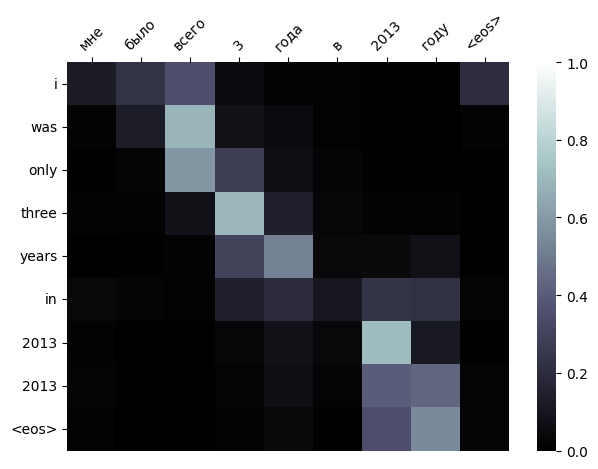

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("он любит играть в футбол", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
print(translation)

['he', 'likes', 'playing', 'soccer', '<eos>']


In [ ]:
attn_frame

,он,любит,играть,в,футбол,<eos>
he,0.083255,0.146077,0.128192,0.024435,0.033106,0.581924
likes,0.012029,0.763198,0.158130,0.014539,0.009319,0.037416
playing,0.018361,0.104592,0.548200,0.096618,0.196731,0.032782
soccer,0.001415,0.000698,0.103723,0.038072,0.842648,0.012498
<eos>,0.006665,0.005863,0.044130,0.048843,0.858849,0.025216


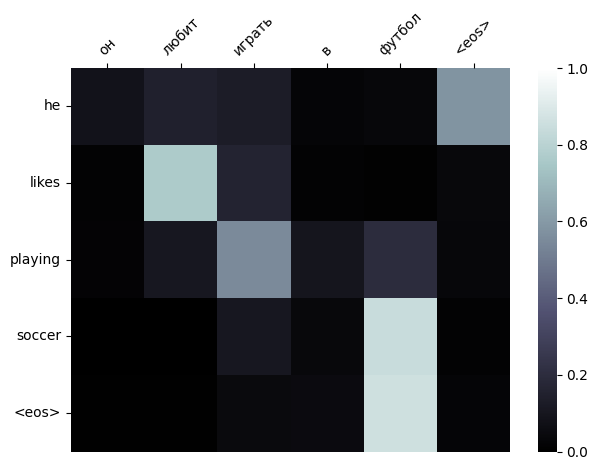

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("Россия самая большая страна в мире", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
print(translation)

['the', 'most', 'great', 'country', 'in', 'the', 'in', 'the', 'the', 'world', '<eos>']


In [ ]:
attn_frame

,Россия,самая,большая,страна,в,мире,<eos>
the,0.583791,0.185672,0.032353,0.030760,0.018149,0.003620,0.084672
most,0.494463,0.352941,0.109962,0.020271,0.000623,0.003428,0.000618
great,0.115152,0.271444,0.303514,0.303997,0.001952,0.000930,0.000290
country,0.029083,0.030570,0.052513,0.875349,0.009548,0.002139,0.000226
in,0.060496,0.055221,0.036529,0.383429,0.418724,0.035809,0.005665
the,0.040380,0.017094,0.019644,0.075713,0.313512,0.520444,0.008567
in,0.019874,0.012745,0.011086,0.075671,0.223430,0.610932,0.039652
the,0.012995,0.008085,0.006000,0.056535,0.153786,0.663747,0.093308
the,0.008647,0.004887,0.002834,0.029520,0.080221,0.752258,0.116168
world,0.001617,0.001029,0.000872,0.005577,0.002783,0.972950,0.014254


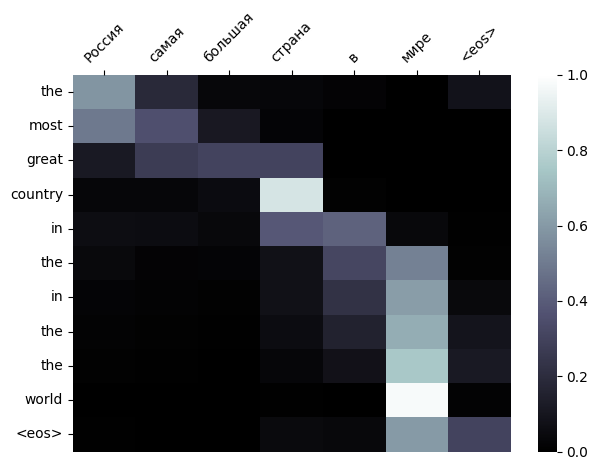

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("Москва красивый город", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
translation

['the', 'is', 'beautiful', 'city', '<eos>']

In [ ]:
attn_frame

,Москва,красивый,город,<eos>
the,0.202507,0.033998,0.041489,0.708110
is,0.542335,0.210998,0.175209,0.041670
beautiful,0.238024,0.288025,0.444976,0.015437
city,0.095525,0.077274,0.803140,0.016903
<eos>,0.241071,0.091892,0.550894,0.066824


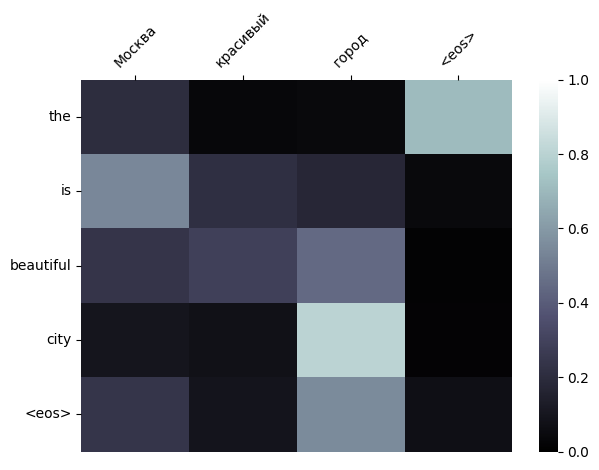

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("я смотрю телевизор", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
translation

['i', 'watch', 'tv', '<eos>']

In [ ]:
attn_frame

,я,смотрю,телевизор,<eos>
i,0.065097,0.108040,0.011008,0.814815
watch,0.046162,0.728734,0.141860,0.079970
tv,0.032457,0.135030,0.785065,0.021570
<eos>,0.043151,0.090763,0.653542,0.121370


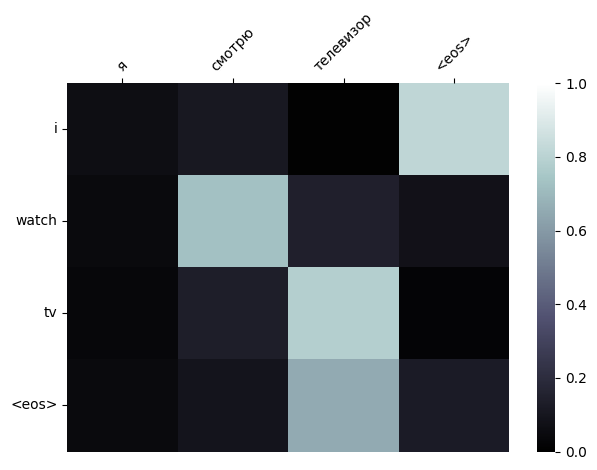

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("Она так красива", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
translation

['the', 's', 'beautiful', 'beautiful', '<eos>']

In [ ]:
attn_frame

,Она,так,красива,<eos>
the,0.264515,0.029650,0.109952,0.576377
s,0.653795,0.070594,0.223001,0.028551
beautiful,0.273717,0.153727,0.528987,0.032780
beautiful,0.121418,0.113056,0.683473,0.066979
<eos>,0.177435,0.092587,0.578525,0.112114


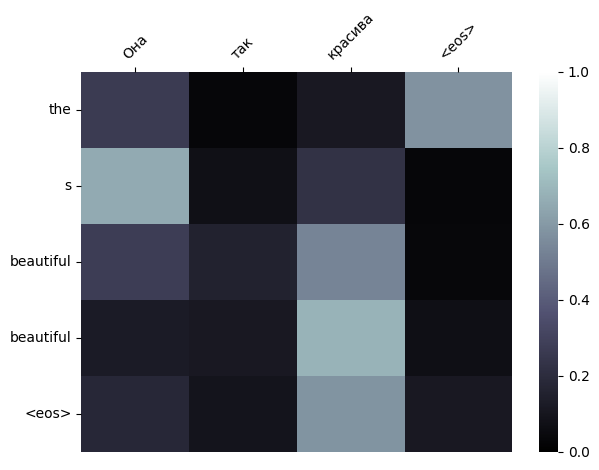

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("Я люблю математику", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
translation

['my', 'math', 'like', 'me', '<eos>']

In [ ]:
attn_frame

,Я,люблю,математику,<eos>
my,0.026975,0.071903,0.116069,0.782340
math,0.074079,0.160614,0.690448,0.066602
like,0.378875,0.376455,0.098687,0.127428
me,0.506259,0.202200,0.157446,0.093793
<eos>,0.518905,0.252527,0.071197,0.072729


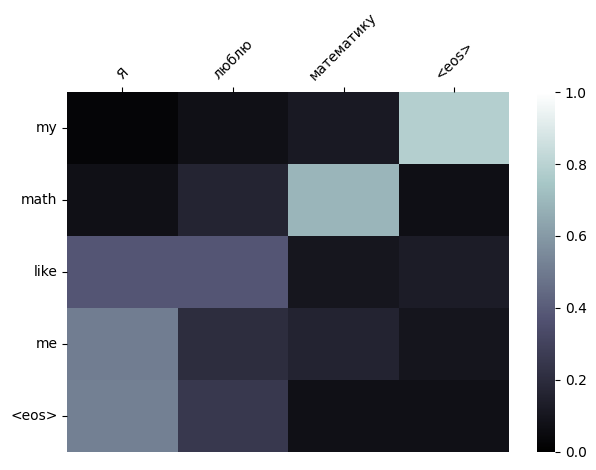

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [50]:
translation, attn_frame = get_translation_and_attention_frame("том целый день нe выключает телевизор", model, rus_tokenizer, en_vocab, ru_vocab)

In [51]:
translation

['tom', 'rented', 'up', 'tv', 'his', 'tv', 'all', 'day', '<eos>']

In [52]:
attn_frame

,том,целый,день,нe,выключает,телевизор,<eos>
tom,0.024356,0.003412,0.006835,0.020996,0.071397,0.059441,0.812793
rented,0.026593,0.030222,0.080725,0.227824,0.362817,0.240595,0.028357
up,0.002183,0.022761,0.012828,0.112569,0.393866,0.449841,0.004506
tv,0.003481,0.030944,0.038017,0.133358,0.232219,0.554752,0.004924
his,0.010638,0.055075,0.123987,0.148599,0.196329,0.452566,0.009063
tv,0.000801,0.064858,0.147264,0.042305,0.043778,0.695654,0.004358
all,0.004746,0.136378,0.566707,0.107283,0.087260,0.071078,0.013147
day,0.013862,0.196604,0.549160,0.118487,0.037595,0.032305,0.025536
<eos>,0.025463,0.104326,0.610797,0.113290,0.022022,0.020142,0.022739


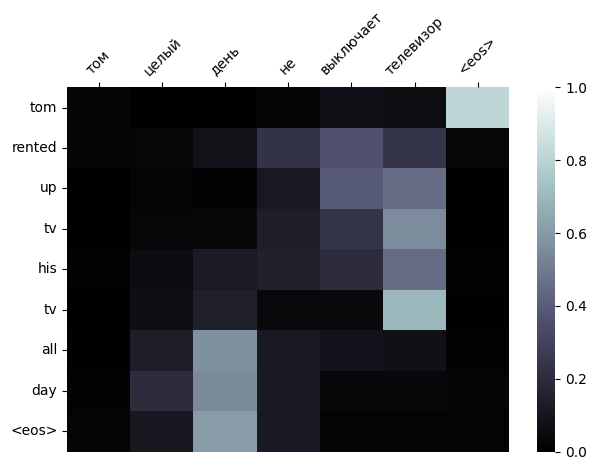

In [53]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [38]:
model = torch.load("/content/gdrive/MyDrive/Russian_English_model_2layer_GRU.pt")

In [39]:
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(60048, 64)
    (gru): GRU(64, 128, num_layers=2, dropout=0.3)
  )
  (decoder): Decoder(
    (embedding): Embedding(17579, 64)
    (gru): GRU(64, 128, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=256, out_features=128, bias=True)
    (out): Linear(in_features=128, out_features=17579, bias=True)
    (attn): Attention()
  )
)

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("мне было всего 3 года в 2013 году", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
print(translation)

['i', 'was', 'only', 'three', 'years', 'in', '2013', '<eos>']


In [ ]:
attn_frame

,мне,было,всего,3,года,в,2013,году,<eos>
i,0.000006,0.238672,0.625794,0.119800,0.006144,0.002449,0.002881,0.002090,0.002164
was,0.000045,0.046658,0.563488,0.376819,0.007075,0.002150,0.002325,0.000715,0.000724
only,0.000162,0.016123,0.147315,0.755015,0.069297,0.008530,0.002551,0.000582,0.000422
three,0.000918,0.020470,0.043308,0.397055,0.453846,0.060302,0.015774,0.005316,0.002793
years,0.000592,0.014368,0.011452,0.043326,0.397116,0.305017,0.137387,0.053064,0.037475
in,0.001248,0.013809,0.005554,0.017358,0.131097,0.193480,0.235463,0.237982,0.163622
2013,0.001643,0.017055,0.003215,0.001205,0.021379,0.068491,0.161949,0.371461,0.353377
<eos>,0.000018,0.002336,0.001357,0.000194,0.001944,0.020594,0.051141,0.185176,0.737231


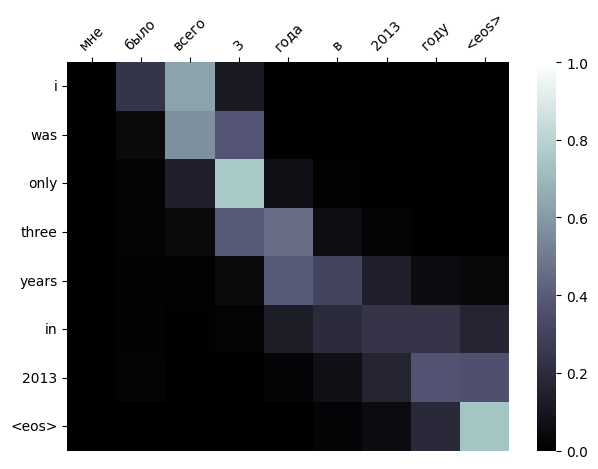

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("он любит играть в футбол", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
print(translation)

['he', 'likes', 'to', 'play', 'soccer', '<eos>']


In [ ]:
attn_frame

,он,любит,играть,в,футбол,<eos>
he,0.000022,0.768030,0.190750,0.028166,0.008264,0.004768
likes,0.001121,0.145489,0.667918,0.143949,0.028598,0.012924
to,0.000238,0.017724,0.225862,0.407603,0.242745,0.105822
play,0.000173,0.002497,0.011202,0.354926,0.326718,0.304482
soccer,0.000493,0.000642,0.000600,0.017489,0.313028,0.667726
<eos>,0.014871,0.016234,0.011872,0.013555,0.109195,0.834109


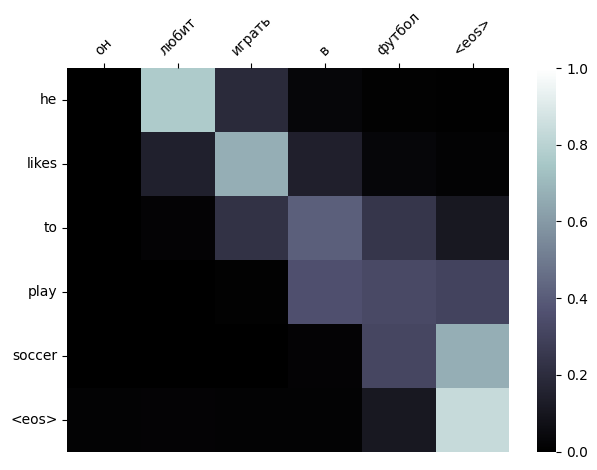

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("Россия самая большая страна в мире", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
translation

['the', 'is', 'the', 'largest', 'country', 'in', 'the', 'world', '<eos>']

In [ ]:
attn_frame

,Россия,самая,большая,страна,в,мире,<eos>
the,0.000035,0.448467,0.178620,0.295914,0.067380,0.006256,0.003330
is,0.000389,0.161335,0.307959,0.400068,0.121812,0.007336,0.001093
the,0.000790,0.094102,0.599582,0.248119,0.041840,0.013968,0.001526
largest,0.000383,0.041134,0.357117,0.550051,0.032709,0.011143,0.006677
country,0.002761,0.042912,0.172621,0.259097,0.344855,0.131591,0.042813
in,0.002000,0.049060,0.105129,0.057320,0.048120,0.374223,0.361237
the,0.002896,0.011290,0.024770,0.012907,0.003267,0.137527,0.805559
world,0.000111,0.004755,0.012862,0.005550,0.001706,0.017633,0.957179
<eos>,0.001009,0.019709,0.017080,0.003380,0.014696,0.059516,0.883431


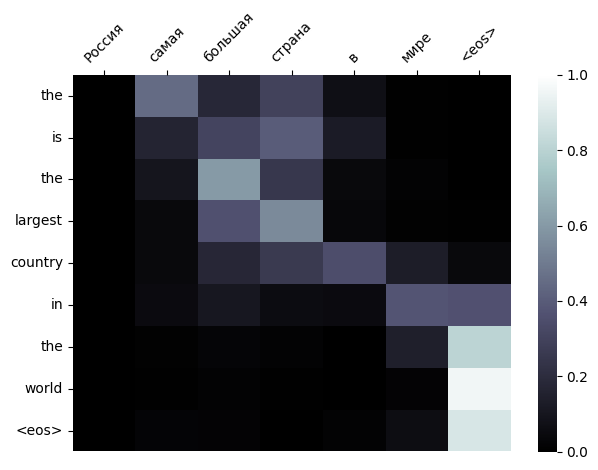

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("Москва красивый город", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
print(translation)

['is', 'are', 'beautiful', '<eos>']


In [ ]:
attn_frame

,Москва,красивый,город,<eos>
is,0.000065,0.616419,0.316282,0.067233
are,0.002170,0.346037,0.496310,0.155450
beautiful,0.000407,0.140113,0.794649,0.064761
<eos>,0.000298,0.033408,0.427732,0.538227


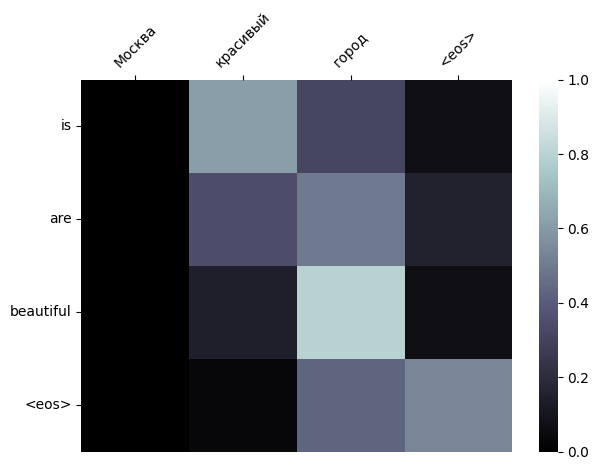

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("я смотрю телевизор", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
translation

['i', 'watch', 'television', '<eos>']

In [ ]:
attn_frame

,я,смотрю,телевизор,<eos>
i,0.000140,0.602001,0.293272,0.104588
watch,0.013787,0.268538,0.391030,0.326628
television,0.002552,0.028082,0.316373,0.652919
<eos>,0.001278,0.033384,0.137732,0.827575


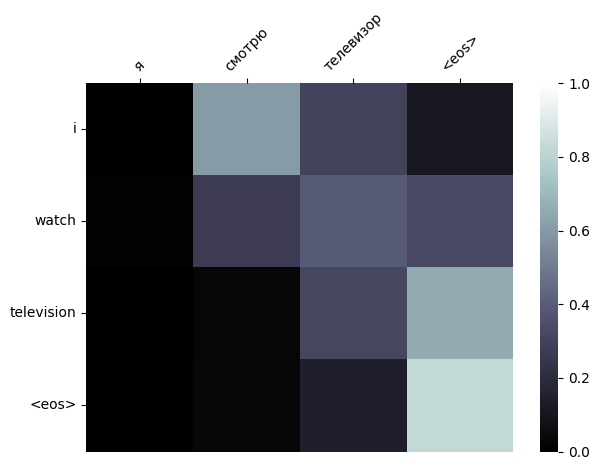

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("Она так красива", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
print(translation)

['is', 'that', 's', 'so', 'beautiful', '<eos>']


In [ ]:
attn_frame

,Она,так,красива,<eos>
is,0.000084,0.568776,0.196510,0.234630
that,0.000616,0.240954,0.499646,0.258781
s,0.003774,0.238835,0.402256,0.354721
so,0.003542,0.125741,0.391470,0.478045
beautiful,0.001557,0.020115,0.032621,0.944731
<eos>,0.000353,0.123547,0.146182,0.729857


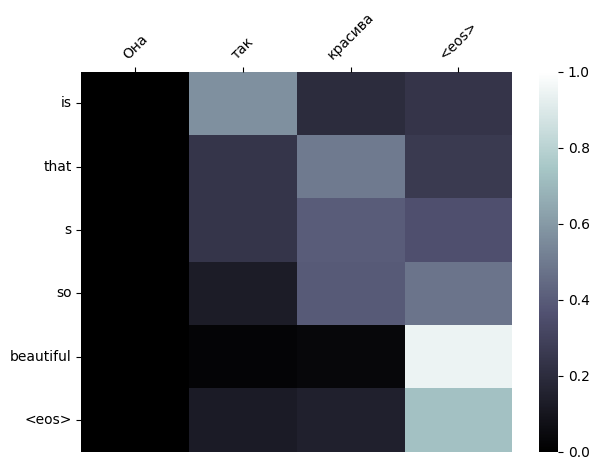

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("Я люблю математику", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
translation

['i', 'like', 'mathematics', '<eos>']

In [ ]:
attn_frame

,Я,люблю,математику,<eos>
i,0.000004,0.677060,0.264052,0.058884
like,0.000447,0.285720,0.652700,0.061122
mathematics,0.003969,0.195691,0.117204,0.682314
<eos>,0.002257,0.167784,0.077742,0.751764


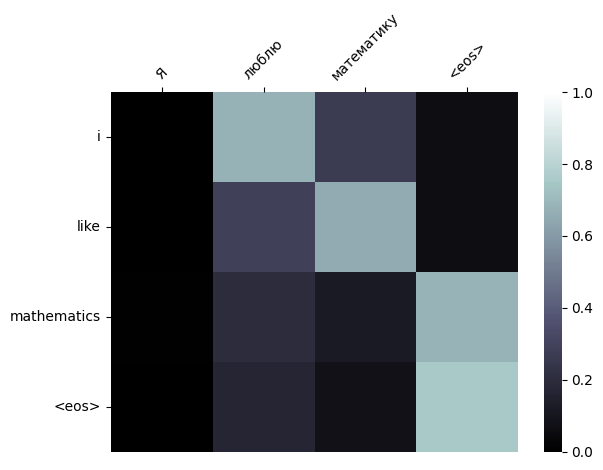

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [40]:
translation, attn_frame = get_translation_and_attention_frame("том целый день нe выключает телевизор", model, rus_tokenizer, en_vocab, ru_vocab)

In [41]:
translation

['tom', 'is', 'off', 'his', 'tv', 'all', 'day', '<eos>']

In [42]:
attn_frame

,том,целый,день,нe,выключает,телевизор,<eos>
tom,0.000021,0.500027,0.039040,0.075824,0.111339,0.128515,0.145233
is,0.000149,0.068909,0.065531,0.163297,0.324466,0.186155,0.191493
off,0.000322,0.067314,0.106487,0.070095,0.431871,0.158643,0.165251
his,0.000956,0.041078,0.148401,0.098125,0.252544,0.220061,0.238604
tv,0.001387,0.010656,0.167823,0.094053,0.049424,0.258599,0.417750
all,0.000524,0.011278,0.451956,0.374937,0.070567,0.032968,0.057437
day,0.001530,0.007293,0.543829,0.380354,0.032484,0.014275,0.019662
<eos>,0.000950,0.019295,0.405641,0.373311,0.076346,0.071418,0.052720


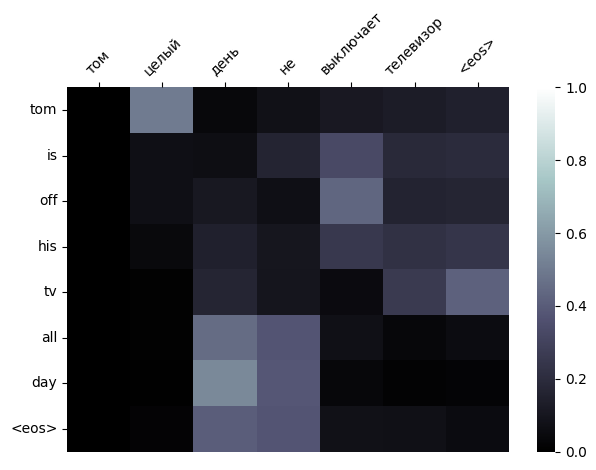

In [43]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()